In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import sys
import pickle
import gzip
from tensorflow.keras.datasets import mnist
import tensorflow
import timeit
import sys
from matplotlib.pyplot import figure

In [2]:
global newton_x_epochs
global newton_accuracy_list
global newton_y_loss

global gd_x_epochs
global gd_accuracy_list
global gd_y_loss

global Adam_x_epochs
global Adam_accuracy_list
global Adam_y_loss

global RMSprop_x_epochs
global RMSprop_accuracy_list
global RMSprop_y_loss

global Adamax_x_epochs
global Adamax_accuracy_list
global Adamax_y_loss

# Newton Method

epochs:1 | runtime: 1.316 s | Loss:1.9249995123089874 | Accuracy: 44.8 %
epochs:2 | runtime: 1.686 s | Loss:1.5947981727692528 | Accuracy: 68.917 %
epochs:3 | runtime: 1.977 s | Loss:1.3641345931975493 | Accuracy: 74.567 %
epochs:4 | runtime: 1.389 s | Loss:1.205825398631252 | Accuracy: 76.617 %
epochs:5 | runtime: 1.447 s | Loss:1.095862305438228 | Accuracy: 77.517 %
epochs:6 | runtime: 1.336 s | Loss:1.0174638360806456 | Accuracy: 77.917 %
epochs:7 | runtime: 1.51 s | Loss:0.9600354460534747 | Accuracy: 77.9 %
epochs:8 | runtime: 1.514 s | Loss:0.9169829217313108 | Accuracy: 78.1 %
epochs:9 | runtime: 1.355 s | Loss:0.8841192497167696 | Accuracy: 78.2 %
epochs:10 | runtime: 1.531 s | Loss:0.8587037235488222 | Accuracy: 78.167 %
epochs:11 | runtime: 1.34 s | Loss:0.838884309976331 | Accuracy: 78.217 %
epochs:12 | runtime: 1.545 s | Loss:0.823371397301521 | Accuracy: 78.1 %
epochs:13 | runtime: 1.4 s | Loss:0.8112422855693088 | Accuracy: 78.0 %
epochs:14 | runtime: 1.697 s | Loss:0.801

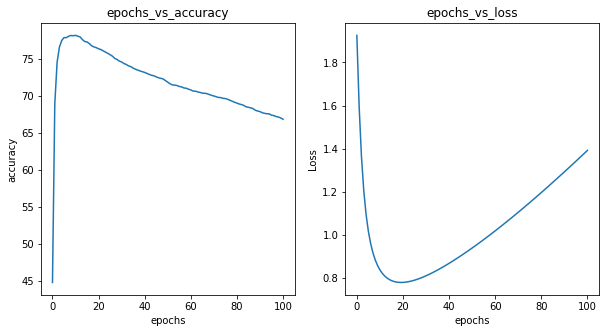

Training accuracy: 66.86666666666666 %
Testing accuracy: 66.9 %


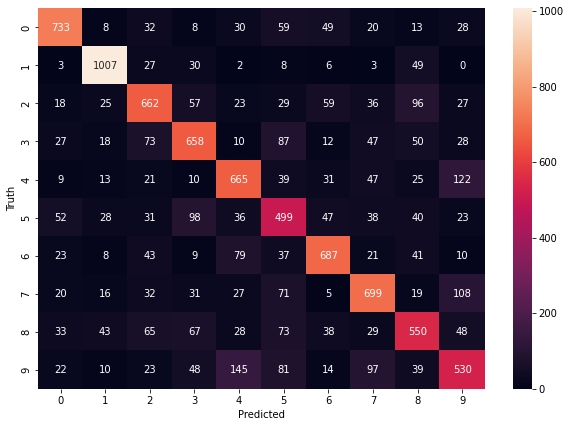

In [3]:
def load_mnist_dataset():
    f = gzip.open('mnist.pkl.gz', 'rb')
    if sys.version_info < (3,):
        data = pickle.load(f)
    else:
        data = pickle.load(f, encoding='bytes')
    f.close()

    return data

class tanh:
    @staticmethod
    def activation(x):
        y = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
        return y

    @staticmethod
    def prime(x):
        y = 1 - (tanh.activation(x) ** 2)
        return y

class sigmoid:
    @staticmethod
    def activation(x):
        y = 1 / (1 + np.exp(-x))
        return y

    @staticmethod
    def prime(x):
        y = sigmoid.activation(x) * (1 - sigmoid.activation(x))
        return y

class relu:
    @staticmethod
    def activation(x):
        y = np.maximum(0, x)
        return y

    @staticmethod
    def prime(x):
        x[x <= 0] = 0
        x[x > 0] = 1
        return x

class softmax:
    @staticmethod
    def activation(x):
        exps = np.exp(x - np.max(x))
        return exps / np.sum(exps, axis=1).reshape(-1, 1)

class Initialization:

    @staticmethod
    def Zeros(input_channel, output_channel):
        w = np.zeros((input_channel, output_channel))
        sdw = np.zeros((input_channel, output_channel))
        vdw = np.zeros((input_channel, output_channel))

        b = np.zeros((1, output_channel))
        sdb = np.zeros((1, output_channel))
        vdb = np.zeros((1, output_channel))

        return w, b, sdw, sdb, vdw, vdb

    @staticmethod
    def Xavier(input_channel, output_channel):
        w = np.random.randn(input_channel, output_channel) * np.sqrt(1 / input_channel)
        sdw = np.zeros((input_channel, output_channel))
        vdw = np.zeros((input_channel, output_channel))

        b = np.zeros((1, output_channel))
        sdb = np.zeros((1, output_channel))
        vdb = np.zeros((1, output_channel))

        return w, b, sdw, sdb, vdw, vdb

    @staticmethod
    def He(input_channel, output_channel):
        w = np.random.randn(input_channel, output_channel) * np.sqrt(2 / input_channel)
        sdw = np.zeros((input_channel, output_channel))
        vdw = np.zeros((input_channel, output_channel))

        b = np.zeros((1, output_channel))
        sdb = np.zeros((1, output_channel))
        vdb = np.zeros((1, output_channel))

        return w, b, sdw, sdb, vdw, vdb

    @staticmethod
    def Kumar(input_channel, output_channel):
        w = np.random.randn(input_channel, output_channel) * np.sqrt(12.96 / input_channel)
        sdw = np.zeros((input_channel, output_channel))
        vdw = np.zeros((input_channel, output_channel))

        b = np.zeros((1, output_channel))
        sdb = np.zeros((1, output_channel))
        vdb = np.zeros((1, output_channel))

        return w, b, sdw, sdb, vdw, vdb

class optimizers():

    @staticmethod
    def Newton(index, ddw, ddb, dw, db):
        model.layers[index].weight += np.matmul(np.linalg.inv(ddw), dw)
        model.layers[index].bias += ddb #np.matmul(np.linalg.inv(ddb), db)
        # print(f"model.layers[index].bias.shape={model.layers[index].bias.shape},model.layers[index].bias.type={type(model.layers[index].bias)}")

    @staticmethod
    def GD(index, dw, db, learning_rate):
        model.layers[index].weight -= learning_rate * dw
        model.layers[index].bias -= learning_rate * db

    @staticmethod
    def RMSprop(index, gamma, dw, db, vdw, vdb, learning_rate):
        vdw = gamma * vdw + (1 - gamma) * dw ** 2
        vdb = gamma * vdb + (1 - gamma) * db ** 2

        model.layers[index].weight -= (learning_rate / (np.sqrt(vdw + 1e-08))) * dw
        model.layers[index].bias -= (learning_rate / (np.sqrt(vdb + 1e-08))) * db

    @staticmethod
    def Adam(index, gamma1, gamma2, dw, db, mdw, mdb, vdw, vdb, currentepoch, alpha):
        mdw = gamma1 * mdw + (1 - gamma1) * dw
        mdb = gamma1 * mdb + (1 - gamma1) * db

        vdw = gamma2 * vdw + (1 - gamma2) * dw ** 2
        vdb = gamma2 * vdb + (1 - gamma2) * db ** 2

        mdw_corr = mdw / (1 - np.power(gamma1, currentepoch + 1))
        mdb_corr = mdb / (1 - np.power(gamma1, currentepoch + 1))

        vdw_corr = vdw / (1 - np.power(gamma2, currentepoch + 1))
        vdb_corr = vdb / (1 - np.power(gamma2, currentepoch + 1))

        model.layers[index].weight -= (alpha / (np.sqrt(vdw_corr + 1e-08))) * mdw_corr
        model.layers[index].bias -= (alpha / (np.sqrt(vdb_corr + 1e-08))) * mdb_corr

    @staticmethod
    def Adamax(index, gamma1, gamma2, dw, db, vdw, vdb, sdw, sdb, currentepoch, learning_rate):
        vdw = gamma1 * vdw + (1 - gamma1) * dw
        vdb = gamma1 * vdb + (1 - gamma1) * db

        sdw = np.maximum(gamma2 * sdw, np.abs(dw))
        sdb = np.maximum(gamma2 * sdb, np.abs(db))

        vdw_corr = vdw / (1 - np.power(gamma1, currentepoch + 1))
        vdb_corr = vdb / (1 - np.power(gamma1, currentepoch + 1))

        model.layers[index].weight -= (learning_rate / (np.sqrt(sdw + 1e-08))) * vdw_corr
        model.layers[index].bias -= (learning_rate / (np.sqrt(sdb + 1e-08))) * vdb_corr

class layers():
    class Dense():
        def __init__(self, input_channel, output_channel, activation=None, initialization=None):

            self.initialization = initialization

            if self.initialization == 'Xavier':
                self.weight, self.bias, self.sdw, self.sdb, self.vdw, self.vdb = \
                    Initialization.Xavier(input_channel, output_channel)
            elif self.initialization == 'He':
                self.weight, self.bias, self.sdw, self.sdb, self.vdw, self.vdb = \
                    Initialization.He(input_channel, output_channel)
            elif self.initialization == 'Kumar':
                self.weight, self.bias, self.sdw, self.sdb, self.vdw, self.vdb = \
                    Initialization.Kumar(input_channel, output_channel)
            else:
                self.weight, self.bias, self.sdw, self.sdb, self.vdw, self.vdb = \
                    Initialization.Zeros(input_channel, output_channel)

            model.activations.append(activation)
            self.activation = activation

        def forward(self, X):
            self.X = X

            z = np.dot(self.X, self.weight) + self.bias
            return z

        def backward(self):
            return self.X.T

class CategoricalCrossEntropy():
    def __init__(self, z, y_true):
        self.y_predict = z
        self.y_true = y_true

    def forward(self):
        m = self.y_predict.shape[0]

        return (-1) * (1 / m) * np.sum((self.y_true * np.log(self.y_predict)))

    def backward(self):
        delta = self.y_predict - self.y_true
        return delta

class BinaryCrossEntropy:
    def __init__(self, z, y_true):
        self.y_predict = z
        self.y_true = y_true

    def forward(self):
        m = self.y_predict.shape[0]
        return (-1) * (1 / m) * (np.sum((self.y_true * np.log(self.y_predict + 1e-8)) +
                                        ((1 - self.y_true) * (np.log(1 - self.y_predict + 1e-8)))))

    def backward(self):
        delta = self.y_predict - self.y_true
        return delta

class sequential():

    def __init__(self):
        self.layers = []
        self.activations = []
        self.Loss_list = []
        self.epochs_list = []
        self.accuracy_list = []

    def add(self, layer):
        self.layers.append(layer)
        return layer

    def compile(self, loss, optimizer):
        self.cost = loss
        self.optimizer = optimizer

    def GDScheduler(self, lr):
        self.learning_rate = lr

    def fit(self, X_train, y_train, batch_size, epochs):

        global cost_function, cost, accuracy
        # global gd_x_epochs, gd_accuracy_list, gd_y_loss
        global newton_x_epochs, newton_accuracy_list, newton_y_loss
        m = X_train.shape[0]
        _z = []
        _a = []
        for i in range(epochs):
            current_epoch = i
            start = timeit.default_timer()

            for p in range(m // batch_size):

                k = p * batch_size
                l = (p + 1) * batch_size
                a = X_train[k:l]
                y = y_train[k:l]
                # Feed forward
                for j, eachLayer in enumerate(model.layers):
                    z = eachLayer.forward(a)
                    _z.append(z)
                    a = eval(model.activations[j]).activation(z)
                    _a.append(a)                                    # Storing activation values for back propogation

                # Calculating cost function
                if self.cost == 'BinaryCrossEntropy':
                    cost_function = 'BinaryCrossEntropy'

                if self.cost == 'CategoricalCrossEntropy':
                    cost_function = 'CategoricalCrossEntropy'

                loss = eval(cost_function)(a, y)
                cost = loss.forward()

                # Backpropagation
                delta = a - y
                deliver_delta = delta
                for j in reversed(range(1, len(model.layers))):

                    # print(f"_a[j - 1].T.shape={_a[j - 1].T.shape},deliver_delta.shape={deliver_delta.shape}")
                    dw = (1 / m) *np.dot(_a[j - 1].T, deliver_delta)# 
                    db = (1 / m) *np.sum(deliver_delta)# 
                    # print(f"dw.shape={dw.shape},db.shape={db.shape}, db.type={type(db)}, db={db}")
                    ddw =  (-1 / m) *np.dot(_a[j - 1].T, _a[j - 1]) #
                    # ddb = db
                    # print(f"ddw.shape={ddw.shape},db.shape={ddb.shape}, db.type={type(ddb)}, db={ddb}")



                    deliver_delta = np.dot(deliver_delta, model.layers[j].weight.T) * \
                                    eval(model.activations[j - 1]).prime(_z[j - 1])

                    # update parameters
                    if self.optimizer == 'Newton':
                        optimizers.Newton(j, ddw, db, dw, db)

                    if self.optimizer == 'GD':
                        optimizers.GD(j, dw, db, self.learning_rate)

                    if self.optimizer == 'RMSprop':
                        optimizers.RMSprop(j, 0.9, dw, db, model.layers[j].sdw, model.layers[j].sdb, self.learning_rate)

                    if self.optimizer == 'Adam':
                        optimizers.Adam(j, 0.9, 0.999, dw, db, model.layers[j].vdw, model.layers[j].vdb,
                                        model.layers[j].sdw, model.layers[j].sdb, current_epoch, self.learning_rate)

                    if self.optimizer == 'Adamax':
                        optimizers.Adamax(j, 0.9, 0.999, dw, db, model.layers[j].vdw, model.layers[j].vdb,
                                          model.layers[j].sdw, model.layers[j].sdb, current_epoch,
                                          self.learning_rate)

                accuracy = np.mean(np.equal(np.argmax(y, axis=-1), np.argmax(a, axis=-1))) * 100

            end = timeit.default_timer()

            print("epochs:" + str(i + 1) + " | " +
                  "runtime: {} s".format(float(round(end - start, 3))) + " | " +
                  "Loss:" + str(cost) + " | " +
                  "Accuracy: {} %".format(float(round(accuracy, 3))))

            #if i % 10 == 0:
            self.accuracy_list.append(accuracy)
            self.Loss_list.append(cost)
            self.epochs_list.append(i)

        # accuracy Plot
        accuracy_list = np.array(self.accuracy_list)
        accuracy_list = accuracy_list.reshape(-1, 1)

        # Loss Plot
        loss_array = np.array(self.Loss_list)
        y_loss = loss_array.reshape(-1, 1)
        x_epochs = np.array(self.epochs_list).reshape(-1, 1)

        accuracy_data = pd.DataFrame()
        accuracy_data['0'] = x_epochs.reshape(1, -1)[0]
        accuracy_data['1'] = accuracy_list.reshape(1, -1)[0]
        accuracy_data.to_csv('accuracy.txt', index=False, header=False, sep=" ")

        loss_data = pd.DataFrame()
        loss_data['0'] = x_epochs.reshape(1, -1)[0]
        loss_data['1'] = y_loss.reshape(1, -1)[0]
        loss_data.to_csv('cost.txt', index=False, header=False, sep=" ")

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.plot(x_epochs, accuracy_list)
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
        plt.title('epochs_vs_accuracy')
        plt.subplot(1, 2, 2)
        plt.plot(x_epochs, y_loss)
        plt.xlabel('epochs')
        plt.ylabel('Loss')
        plt.title('epochs_vs_loss')

        fig1 = plt.gcf()
        plt.show()
        fig1.savefig('Results.png')

        print("Training accuracy: {} %".format(accuracy))

        newton_x_epochs     = x_epochs
        newton_accuracy_list= accuracy_list
        newton_y_loss       = y_loss

    @staticmethod
    def predict(x):

        a = x
        for j, eachLayer in enumerate(model.layers):
            z = eachLayer.forward(a)
            a = eval(model.activations[j]).activation(z)

        return a

    @staticmethod
    def confusion_matrix(data_array, labels):

        dim = len(data_array[0])
        cm = np.zeros((dim, dim), int)

        for i in range(len(data_array)):
            truth = np.argmax(data_array[i])
            predicted = np.argmax(labels[i])
            cm[truth, predicted] += 1

        plt.figure(figsize=(10, 7))
        sn.heatmap(cm, annot=True, fmt='d')
        plt.xlabel("Predicted")
        plt.ylabel("Truth")

        fig1 = plt.gcf()
        plt.show()
        fig1.savefig('cm.png')
        return cm

def evaluate(y_test, y_predicted):
    accuracy = np.mean(np.equal(np.argmax(y_test, axis=-1), np.argmax(y_predicted, axis=-1))) * 100
    print("Testing accuracy: {} %".format(accuracy))

if __name__ == '__main__':
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    X_train = X_train / 255
    X_test = X_test / 255

    y_train = tensorflow.keras.utils.to_categorical(y_train, 10).T
    y_test = tensorflow.keras.utils.to_categorical(y_test, 10).T

    X_train = X_train.reshape(-1, 28 * 28)
    X_test = X_test.reshape(-1, 28 * 28)
    y_train = y_train.T
    y_test = y_test.T

    model = sequential()

    model.add(layers.Dense(784, 100, activation='relu', initialization='He'))
    model.add(layers.Dense(100, 10, activation='softmax', initialization='He'))

    model.compile(loss='CategoricalCrossEntropy', optimizer='Newton')
    model.GDScheduler(lr=0.01)
    model.fit(X_train, y_train, batch_size=6000, epochs=101)

    y_predicted = model.predict(X_test)

    evaluate(y_test, y_predicted)
    model.confusion_matrix(y_test, y_predicted)


# Gradient Descent Method

epochs:1 | runtime: 0.748 s | Loss:127.2421137935844 | Accuracy: 9.917 %
epochs:2 | runtime: 1.821 s | Loss:112.472218843796 | Accuracy: 14.467 %
epochs:3 | runtime: 1.769 s | Loss:53.769746654134316 | Accuracy: 34.567 %
epochs:4 | runtime: 1.749 s | Loss:38.9935123951183 | Accuracy: 35.267 %
epochs:5 | runtime: 1.705 s | Loss:27.805757345103096 | Accuracy: 46.45 %
epochs:6 | runtime: 1.703 s | Loss:35.11399355954979 | Accuracy: 49.65 %
epochs:7 | runtime: 1.662 s | Loss:20.907807323072053 | Accuracy: 44.333 %
epochs:8 | runtime: 1.637 s | Loss:22.474552041903525 | Accuracy: 53.417 %
epochs:9 | runtime: 1.625 s | Loss:10.283327706050187 | Accuracy: 52.817 %
epochs:10 | runtime: 1.578 s | Loss:9.965375130399602 | Accuracy: 66.65 %
epochs:11 | runtime: 1.53 s | Loss:4.262387181722936 | Accuracy: 64.567 %
epochs:12 | runtime: 1.473 s | Loss:10.749070049026576 | Accuracy: 41.7 %
epochs:13 | runtime: 1.471 s | Loss:6.41007073382064 | Accuracy: 54.667 %
epochs:14 | runtime: 1.398 s | Loss:5.

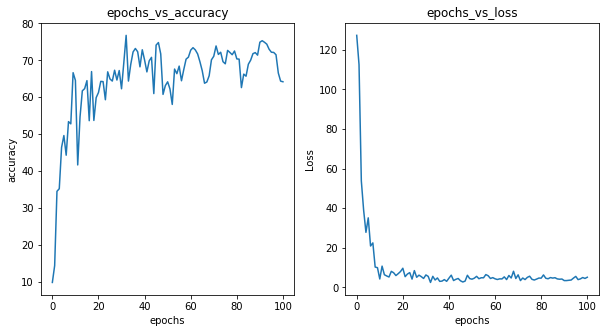

Training accuracy: 64.2 %
Testing accuracy: 63.739999999999995 %


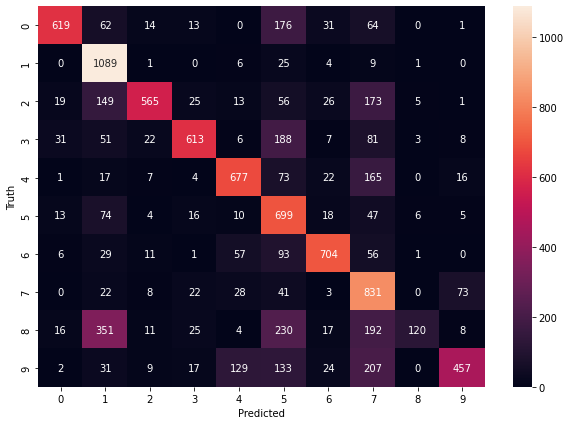

In [4]:
def load_mnist_dataset():
    f = gzip.open('mnist.pkl.gz', 'rb')
    if sys.version_info < (3,):
        data = pickle.load(f)
    else:
        data = pickle.load(f, encoding='bytes')
    f.close()

    return data

class tanh:
    @staticmethod
    def activation(x):
        y = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
        return y

    @staticmethod
    def prime(x):
        y = 1 - (tanh.activation(x) ** 2)
        return y

class sigmoid:
    @staticmethod
    def activation(x):
        y = 1 / (1 + np.exp(-x))
        return y

    @staticmethod
    def prime(x):
        y = sigmoid.activation(x) * (1 - sigmoid.activation(x))
        return y

class relu:
    @staticmethod
    def activation(x):
        y = np.maximum(0, x)
        return y

    @staticmethod
    def prime(x):
        x[x <= 0] = 0
        x[x > 0] = 1
        return x

class softmax:
    @staticmethod
    def activation(x):
        exps = np.exp(x - np.max(x))
        return exps / np.sum(exps, axis=1).reshape(-1, 1)

class Initialization:

    @staticmethod
    def Zeros(input_channel, output_channel):
        w = np.zeros((input_channel, output_channel))
        sdw = np.zeros((input_channel, output_channel))
        vdw = np.zeros((input_channel, output_channel))

        b = np.zeros((1, output_channel))
        sdb = np.zeros((1, output_channel))
        vdb = np.zeros((1, output_channel))

        return w, b, sdw, sdb, vdw, vdb

    @staticmethod
    def Xavier(input_channel, output_channel):
        w = np.random.randn(input_channel, output_channel) * np.sqrt(1 / input_channel)
        sdw = np.zeros((input_channel, output_channel))
        vdw = np.zeros((input_channel, output_channel))

        b = np.zeros((1, output_channel))
        sdb = np.zeros((1, output_channel))
        vdb = np.zeros((1, output_channel))

        return w, b, sdw, sdb, vdw, vdb

    @staticmethod
    def He(input_channel, output_channel):
        w = np.random.randn(input_channel, output_channel) * np.sqrt(2 / input_channel)
        sdw = np.zeros((input_channel, output_channel))
        vdw = np.zeros((input_channel, output_channel))

        b = np.zeros((1, output_channel))
        sdb = np.zeros((1, output_channel))
        vdb = np.zeros((1, output_channel))

        return w, b, sdw, sdb, vdw, vdb

    @staticmethod
    def Kumar(input_channel, output_channel):
        w = np.random.randn(input_channel, output_channel) * np.sqrt(12.96 / input_channel)
        sdw = np.zeros((input_channel, output_channel))
        vdw = np.zeros((input_channel, output_channel))

        b = np.zeros((1, output_channel))
        sdb = np.zeros((1, output_channel))
        vdb = np.zeros((1, output_channel))

        return w, b, sdw, sdb, vdw, vdb

class optimizers():

    @staticmethod
    def Newton(index, ddw, ddb, dw, db):
        model.layers[index].weight += np.matmul(np.linalg.inv(ddw), dw)
        model.layers[index].bias += ddb #np.matmul(np.linalg.inv(ddb), db)
        # print(f"model.layers[index].bias.shape={model.layers[index].bias.shape},model.layers[index].bias.type={type(model.layers[index].bias)}")

    @staticmethod
    def GD(index, dw, db, learning_rate):
        model.layers[index].weight -= learning_rate * dw
        model.layers[index].bias -= learning_rate * db

    @staticmethod
    def RMSprop(index, gamma, dw, db, vdw, vdb, learning_rate):
        vdw = gamma * vdw + (1 - gamma) * dw ** 2
        vdb = gamma * vdb + (1 - gamma) * db ** 2

        model.layers[index].weight -= (learning_rate / (np.sqrt(vdw + 1e-08))) * dw
        model.layers[index].bias -= (learning_rate / (np.sqrt(vdb + 1e-08))) * db

    @staticmethod
    def Adam(index, gamma1, gamma2, dw, db, mdw, mdb, vdw, vdb, currentepoch, alpha):
        mdw = gamma1 * mdw + (1 - gamma1) * dw
        mdb = gamma1 * mdb + (1 - gamma1) * db

        vdw = gamma2 * vdw + (1 - gamma2) * dw ** 2
        vdb = gamma2 * vdb + (1 - gamma2) * db ** 2

        mdw_corr = mdw / (1 - np.power(gamma1, currentepoch + 1))
        mdb_corr = mdb / (1 - np.power(gamma1, currentepoch + 1))

        vdw_corr = vdw / (1 - np.power(gamma2, currentepoch + 1))
        vdb_corr = vdb / (1 - np.power(gamma2, currentepoch + 1))

        model.layers[index].weight -= (alpha / (np.sqrt(vdw_corr + 1e-08))) * mdw_corr
        model.layers[index].bias -= (alpha / (np.sqrt(vdb_corr + 1e-08))) * mdb_corr

    @staticmethod
    def Adamax(index, gamma1, gamma2, dw, db, vdw, vdb, sdw, sdb, currentepoch, learning_rate):
        vdw = gamma1 * vdw + (1 - gamma1) * dw
        vdb = gamma1 * vdb + (1 - gamma1) * db

        sdw = np.maximum(gamma2 * sdw, np.abs(dw))
        sdb = np.maximum(gamma2 * sdb, np.abs(db))

        vdw_corr = vdw / (1 - np.power(gamma1, currentepoch + 1))
        vdb_corr = vdb / (1 - np.power(gamma1, currentepoch + 1))

        model.layers[index].weight -= (learning_rate / (np.sqrt(sdw + 1e-08))) * vdw_corr
        model.layers[index].bias -= (learning_rate / (np.sqrt(sdb + 1e-08))) * vdb_corr

class layers():
    class Dense():
        def __init__(self, input_channel, output_channel, activation=None, initialization=None):

            self.initialization = initialization

            if self.initialization == 'Xavier':
                self.weight, self.bias, self.sdw, self.sdb, self.vdw, self.vdb = \
                    Initialization.Xavier(input_channel, output_channel)
            elif self.initialization == 'He':
                self.weight, self.bias, self.sdw, self.sdb, self.vdw, self.vdb = \
                    Initialization.He(input_channel, output_channel)
            elif self.initialization == 'Kumar':
                self.weight, self.bias, self.sdw, self.sdb, self.vdw, self.vdb = \
                    Initialization.Kumar(input_channel, output_channel)
            else:
                self.weight, self.bias, self.sdw, self.sdb, self.vdw, self.vdb = \
                    Initialization.Zeros(input_channel, output_channel)

            model.activations.append(activation)
            self.activation = activation

        def forward(self, X):
            self.X = X

            z = np.dot(self.X, self.weight) + self.bias
            return z

        def backward(self):
            return self.X.T

class CategoricalCrossEntropy():
    def __init__(self, z, y_true):
        self.y_predict = z
        self.y_true = y_true

    def forward(self):
        m = self.y_predict.shape[0]

        return (-1) * (1 / m) * np.sum((self.y_true * np.log(self.y_predict)))

    def backward(self):
        delta = self.y_predict - self.y_true
        return delta

class BinaryCrossEntropy:
    def __init__(self, z, y_true):
        self.y_predict = z
        self.y_true = y_true

    def forward(self):
        m = self.y_predict.shape[0]
        return (-1) * (1 / m) * (np.sum((self.y_true * np.log(self.y_predict + 1e-8)) +
                                        ((1 - self.y_true) * (np.log(1 - self.y_predict + 1e-8)))))

    def backward(self):
        delta = self.y_predict - self.y_true
        return delta

class sequential():

    def __init__(self):
        self.layers = []
        self.activations = []
        self.Loss_list = []
        self.epochs_list = []
        self.accuracy_list = []

    def add(self, layer):
        self.layers.append(layer)
        return layer

    def compile(self, loss, optimizer):
        self.cost = loss
        self.optimizer = optimizer

    def GDScheduler(self, lr):
        self.learning_rate = lr

    def fit(self, X_train, y_train, batch_size, epochs):

        global cost_function, cost, accuracy
        global gd_x_epochs, gd_accuracy_list, gd_y_loss
        # global newton_x_epochs, newton_accuracy_list, newton_y_loss
        m = X_train.shape[0]
        _z = []
        _a = []
        for i in range(epochs):
            current_epoch = i
            start = timeit.default_timer()

            for p in range(m // batch_size):

                k = p * batch_size
                l = (p + 1) * batch_size
                a = X_train[k:l]
                y = y_train[k:l]
                # Feed forward
                for j, eachLayer in enumerate(model.layers):
                    z = eachLayer.forward(a)
                    _z.append(z)
                    a = eval(model.activations[j]).activation(z)
                    _a.append(a)                                    # Storing activation values for back propogation

                # Calculating cost function
                if self.cost == 'BinaryCrossEntropy':
                    cost_function = 'BinaryCrossEntropy'

                if self.cost == 'CategoricalCrossEntropy':
                    cost_function = 'CategoricalCrossEntropy'

                loss = eval(cost_function)(a, y)
                cost = loss.forward()

                # Backpropagation
                delta = a - y
                deliver_delta = delta
                for j in reversed(range(1, len(model.layers))):

                    # print(f"_a[j - 1].T.shape={_a[j - 1].T.shape},deliver_delta.shape={deliver_delta.shape}")
                    dw = np.dot(_a[j - 1].T, deliver_delta)# (1 / m) *
                    db = np.sum(deliver_delta)# (1 / m) *
                    # print(f"dw.shape={dw.shape},db.shape={db.shape}, db.type={type(db)}, db={db}")
                    ddw =  (-1 / m) *np.dot(_a[j - 1].T, _a[j - 1]) #
                    # ddb = db
                    # print(f"ddw.shape={ddw.shape},db.shape={ddb.shape}, db.type={type(ddb)}, db={ddb}")



                    deliver_delta = np.dot(deliver_delta, model.layers[j].weight.T) * \
                                    eval(model.activations[j - 1]).prime(_z[j - 1])

                    # update parameters
                    if self.optimizer == 'Newton':
                        optimizers.Newton(j, ddw, db, dw, db)

                    if self.optimizer == 'GD':
                        optimizers.GD(j, dw, db, self.learning_rate)

                    if self.optimizer == 'RMSprop':
                        optimizers.RMSprop(j, 0.9, dw, db, model.layers[j].sdw, model.layers[j].sdb, self.learning_rate)

                    if self.optimizer == 'Adam':
                        optimizers.Adam(j, 0.9, 0.999, dw, db, model.layers[j].vdw, model.layers[j].vdb,
                                        model.layers[j].sdw, model.layers[j].sdb, current_epoch, self.learning_rate)

                    if self.optimizer == 'Adamax':
                        optimizers.Adamax(j, 0.9, 0.999, dw, db, model.layers[j].vdw, model.layers[j].vdb,
                                          model.layers[j].sdw, model.layers[j].sdb, current_epoch,
                                          self.learning_rate)

                accuracy = np.mean(np.equal(np.argmax(y, axis=-1), np.argmax(a, axis=-1))) * 100

            end = timeit.default_timer()

            print("epochs:" + str(i + 1) + " | " +
                  "runtime: {} s".format(float(round(end - start, 3))) + " | " +
                  "Loss:" + str(cost) + " | " +
                  "Accuracy: {} %".format(float(round(accuracy, 3))))

            #if i % 10 == 0:
            self.accuracy_list.append(accuracy)
            self.Loss_list.append(cost)
            self.epochs_list.append(i)

        # accuracy Plot
        accuracy_list = np.array(self.accuracy_list)
        accuracy_list = accuracy_list.reshape(-1, 1)

        # Loss Plot
        loss_array = np.array(self.Loss_list)
        y_loss = loss_array.reshape(-1, 1)
        x_epochs = np.array(self.epochs_list).reshape(-1, 1)

        accuracy_data = pd.DataFrame()
        accuracy_data['0'] = x_epochs.reshape(1, -1)[0]
        accuracy_data['1'] = accuracy_list.reshape(1, -1)[0]
        accuracy_data.to_csv('accuracy.txt', index=False, header=False, sep=" ")

        loss_data = pd.DataFrame()
        loss_data['0'] = x_epochs.reshape(1, -1)[0]
        loss_data['1'] = y_loss.reshape(1, -1)[0]
        loss_data.to_csv('cost.txt', index=False, header=False, sep=" ")

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.plot(x_epochs, accuracy_list)
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
        plt.title('epochs_vs_accuracy')
        plt.subplot(1, 2, 2)
        plt.plot(x_epochs, y_loss)
        plt.xlabel('epochs')
        plt.ylabel('Loss')
        plt.title('epochs_vs_loss')

        fig1 = plt.gcf()
        plt.show()
        fig1.savefig('Results.png')

        print("Training accuracy: {} %".format(accuracy))

        gd_x_epochs     = x_epochs
        gd_accuracy_list= accuracy_list
        gd_y_loss       = y_loss

    @staticmethod
    def predict(x):

        a = x
        for j, eachLayer in enumerate(model.layers):
            z = eachLayer.forward(a)
            a = eval(model.activations[j]).activation(z)

        return a

    @staticmethod
    def confusion_matrix(data_array, labels):

        dim = len(data_array[0])
        cm = np.zeros((dim, dim), int)

        for i in range(len(data_array)):
            truth = np.argmax(data_array[i])
            predicted = np.argmax(labels[i])
            cm[truth, predicted] += 1

        plt.figure(figsize=(10, 7))
        sn.heatmap(cm, annot=True, fmt='d')
        plt.xlabel("Predicted")
        plt.ylabel("Truth")

        fig1 = plt.gcf()
        plt.show()
        fig1.savefig('cm.png')
        return cm

def evaluate(y_test, y_predicted):
    accuracy = np.mean(np.equal(np.argmax(y_test, axis=-1), np.argmax(y_predicted, axis=-1))) * 100
    print("Testing accuracy: {} %".format(accuracy))

if __name__ == '__main__':
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    X_train = X_train / 255
    X_test = X_test / 255

    y_train = tensorflow.keras.utils.to_categorical(y_train, 10).T
    y_test = tensorflow.keras.utils.to_categorical(y_test, 10).T

    X_train = X_train.reshape(-1, 28 * 28)
    X_test = X_test.reshape(-1, 28 * 28)
    y_train = y_train.T
    y_test = y_test.T

    model = sequential()

    model.add(layers.Dense(784, 100, activation='relu', initialization='He'))
    model.add(layers.Dense(100, 10, activation='softmax', initialization='He'))

    model.compile(loss='CategoricalCrossEntropy', optimizer='GD')
    model.GDScheduler(lr=0.01)
    model.fit(X_train, y_train, batch_size=6000, epochs=101)

    y_predicted = model.predict(X_test)

    evaluate(y_test, y_predicted)
    model.confusion_matrix(y_test, y_predicted)

# Compare Results

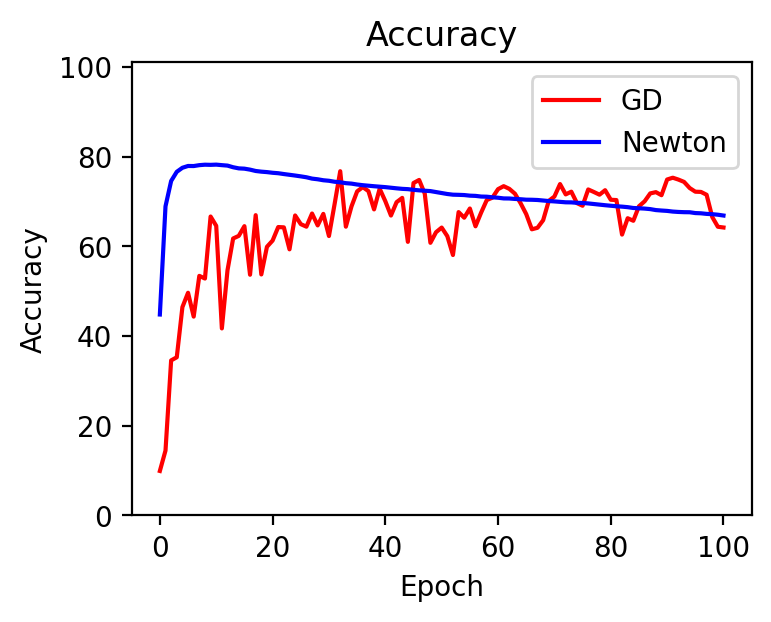

In [5]:
figure(figsize=(4, 3), dpi=200)
t = np.linspace(0,1,101)
plt.plot(gd_x_epochs, gd_accuracy_list, 'r')#gd_x_epochs
plt.plot(newton_x_epochs, newton_accuracy_list, 'b')#newton_x_epochs
plt.ylim(0,101)
plt.legend(["GD", "Newton"])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

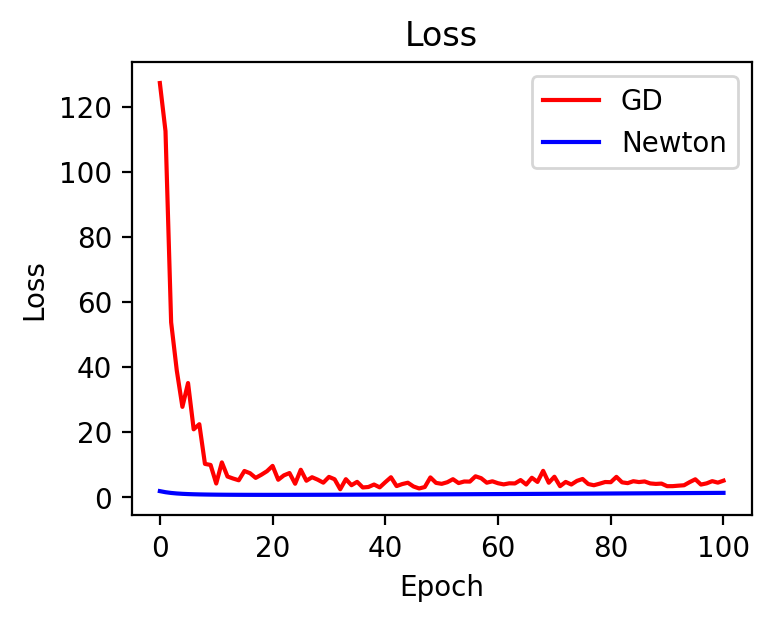

In [6]:
import matplotlib.pyplot as plt
figure(figsize=(4, 3), dpi=200)
t = np.linspace(0,1,101)
plt.plot(gd_x_epochs, gd_y_loss,'r')#gd_x_epochs
plt.plot(newton_x_epochs, newton_y_loss,'b')#newton_x_epochs
plt.legend(["GD", "Newton"])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

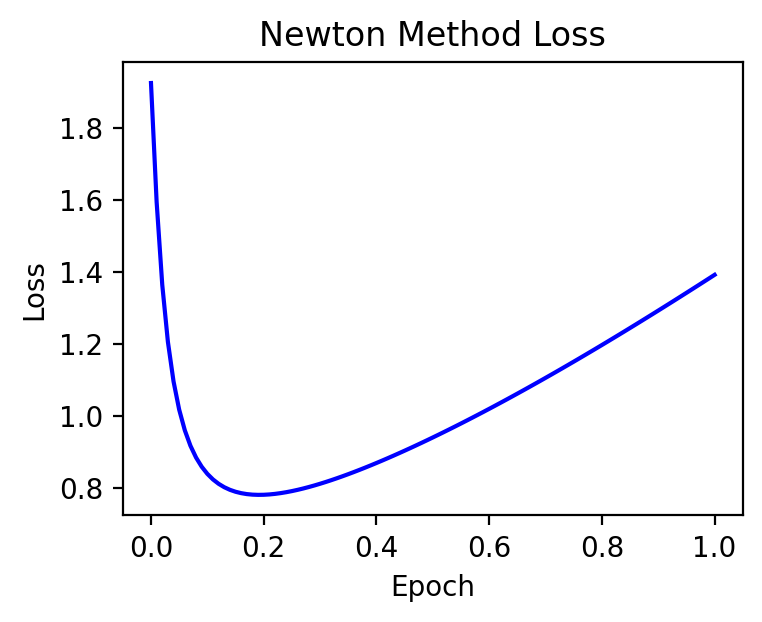

In [7]:
figure(figsize=(4, 3), dpi=200)
t = np.linspace(0,1,101)
plt.plot(t, newton_y_loss,'b')#newton_x_epochs
plt.title('Newton Method Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Adam Method

epochs:1 | runtime: 0.619 s | Loss:2.298353789704057 | Accuracy: 14.483 %
epochs:2 | runtime: 0.678 s | Loss:2.2668756814518587 | Accuracy: 15.633 %
epochs:3 | runtime: 0.671 s | Loss:2.240847327055097 | Accuracy: 17.033 %
epochs:4 | runtime: 0.66 s | Loss:2.220848762703158 | Accuracy: 18.317 %
epochs:5 | runtime: 0.905 s | Loss:2.2072214246307955 | Accuracy: 19.333 %
epochs:6 | runtime: 1.679 s | Loss:2.1957541599276578 | Accuracy: 19.783 %
epochs:7 | runtime: 1.66 s | Loss:2.1855715925450836 | Accuracy: 20.5 %
epochs:8 | runtime: 1.635 s | Loss:2.17620794537247 | Accuracy: 20.217 %
epochs:9 | runtime: 1.572 s | Loss:2.1674125047412924 | Accuracy: 20.633 %
epochs:10 | runtime: 1.566 s | Loss:2.1596706633612865 | Accuracy: 20.633 %
epochs:11 | runtime: 1.55 s | Loss:2.150703461373055 | Accuracy: 20.95 %
epochs:12 | runtime: 1.504 s | Loss:2.1420884446978223 | Accuracy: 20.983 %
epochs:13 | runtime: 1.438 s | Loss:2.1354271070605995 | Accuracy: 20.867 %
epochs:14 | runtime: 1.422 s | Lo

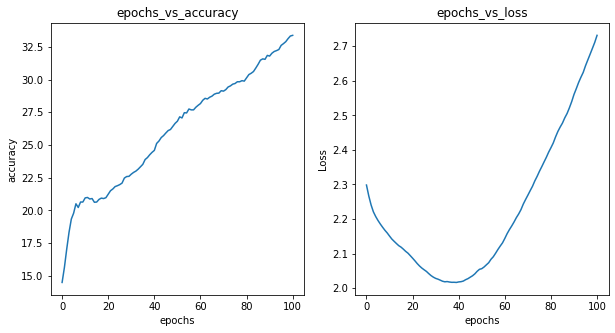

Training accuracy: 33.38333333333333 %
Testing accuracy: 31.6 %


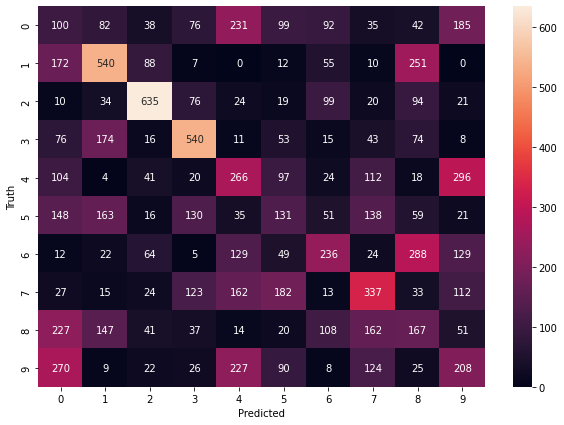

In [8]:
def load_mnist_dataset():
    f = gzip.open('mnist.pkl.gz', 'rb')
    if sys.version_info < (3,):
        data = pickle.load(f)
    else:
        data = pickle.load(f, encoding='bytes')
    f.close()

    return data

class tanh:
    @staticmethod
    def activation(x):
        y = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
        return y

    @staticmethod
    def prime(x):
        y = 1 - (tanh.activation(x) ** 2)
        return y

class sigmoid:
    @staticmethod
    def activation(x):
        y = 1 / (1 + np.exp(-x))
        return y

    @staticmethod
    def prime(x):
        y = sigmoid.activation(x) * (1 - sigmoid.activation(x))
        return y

class relu:
    @staticmethod
    def activation(x):
        y = np.maximum(0, x)
        return y

    @staticmethod
    def prime(x):
        x[x <= 0] = 0
        x[x > 0] = 1
        return x

class softmax:
    @staticmethod
    def activation(x):
        exps = np.exp(x - np.max(x))
        return exps / np.sum(exps, axis=1).reshape(-1, 1)

class Initialization:

    @staticmethod
    def Zeros(input_channel, output_channel):
        w = np.zeros((input_channel, output_channel))
        sdw = np.zeros((input_channel, output_channel))
        vdw = np.zeros((input_channel, output_channel))

        b = np.zeros((1, output_channel))
        sdb = np.zeros((1, output_channel))
        vdb = np.zeros((1, output_channel))

        return w, b, sdw, sdb, vdw, vdb

    @staticmethod
    def Xavier(input_channel, output_channel):
        w = np.random.randn(input_channel, output_channel) * np.sqrt(1 / input_channel)
        sdw = np.zeros((input_channel, output_channel))
        vdw = np.zeros((input_channel, output_channel))

        b = np.zeros((1, output_channel))
        sdb = np.zeros((1, output_channel))
        vdb = np.zeros((1, output_channel))

        return w, b, sdw, sdb, vdw, vdb

    @staticmethod
    def He(input_channel, output_channel):
        w = np.random.randn(input_channel, output_channel) * np.sqrt(2 / input_channel)
        sdw = np.zeros((input_channel, output_channel))
        vdw = np.zeros((input_channel, output_channel))

        b = np.zeros((1, output_channel))
        sdb = np.zeros((1, output_channel))
        vdb = np.zeros((1, output_channel))

        return w, b, sdw, sdb, vdw, vdb

    @staticmethod
    def Kumar(input_channel, output_channel):
        w = np.random.randn(input_channel, output_channel) * np.sqrt(12.96 / input_channel)
        sdw = np.zeros((input_channel, output_channel))
        vdw = np.zeros((input_channel, output_channel))

        b = np.zeros((1, output_channel))
        sdb = np.zeros((1, output_channel))
        vdb = np.zeros((1, output_channel))

        return w, b, sdw, sdb, vdw, vdb

class optimizers():

    @staticmethod
    def Newton(index, ddw, ddb, dw, db):
        model.layers[index].weight += np.matmul(np.linalg.inv(ddw), dw)
        model.layers[index].bias += ddb #np.matmul(np.linalg.inv(ddb), db)
        # print(f"model.layers[index].bias.shape={model.layers[index].bias.shape},model.layers[index].bias.type={type(model.layers[index].bias)}")

    @staticmethod
    def GD(index, dw, db, learning_rate):
        model.layers[index].weight -= learning_rate * dw
        model.layers[index].bias -= learning_rate * db

    @staticmethod
    def RMSprop(index, gamma, dw, db, vdw, vdb, learning_rate):
        vdw = gamma * vdw + (1 - gamma) * dw ** 2
        vdb = gamma * vdb + (1 - gamma) * db ** 2

        model.layers[index].weight -= (learning_rate / (np.sqrt(vdw + 1e-08))) * dw
        model.layers[index].bias -= (learning_rate / (np.sqrt(vdb + 1e-08))) * db

    @staticmethod
    def Adam(index, gamma1, gamma2, dw, db, mdw, mdb, vdw, vdb, currentepoch, alpha):
        mdw = gamma1 * mdw + (1 - gamma1) * dw
        mdb = gamma1 * mdb + (1 - gamma1) * db

        vdw = gamma2 * vdw + (1 - gamma2) * dw ** 2
        vdb = gamma2 * vdb + (1 - gamma2) * db ** 2

        mdw_corr = mdw / (1 - np.power(gamma1, currentepoch + 1))
        mdb_corr = mdb / (1 - np.power(gamma1, currentepoch + 1))

        vdw_corr = vdw / (1 - np.power(gamma2, currentepoch + 1))
        vdb_corr = vdb / (1 - np.power(gamma2, currentepoch + 1))

        model.layers[index].weight -= (alpha / (np.sqrt(vdw_corr + 1e-08))) * mdw_corr
        model.layers[index].bias -= (alpha / (np.sqrt(vdb_corr + 1e-08))) * mdb_corr

    @staticmethod
    def Adamax(index, gamma1, gamma2, dw, db, vdw, vdb, sdw, sdb, currentepoch, learning_rate):
        vdw = gamma1 * vdw + (1 - gamma1) * dw
        vdb = gamma1 * vdb + (1 - gamma1) * db

        sdw = np.maximum(gamma2 * sdw, np.abs(dw))
        sdb = np.maximum(gamma2 * sdb, np.abs(db))

        vdw_corr = vdw / (1 - np.power(gamma1, currentepoch + 1))
        vdb_corr = vdb / (1 - np.power(gamma1, currentepoch + 1))

        model.layers[index].weight -= (learning_rate / (np.sqrt(sdw + 1e-08))) * vdw_corr
        model.layers[index].bias -= (learning_rate / (np.sqrt(sdb + 1e-08))) * vdb_corr

class layers():
    class Dense():
        def __init__(self, input_channel, output_channel, activation=None, initialization=None):

            self.initialization = initialization

            if self.initialization == 'Xavier':
                self.weight, self.bias, self.sdw, self.sdb, self.vdw, self.vdb = \
                    Initialization.Xavier(input_channel, output_channel)
            elif self.initialization == 'He':
                self.weight, self.bias, self.sdw, self.sdb, self.vdw, self.vdb = \
                    Initialization.He(input_channel, output_channel)
            elif self.initialization == 'Kumar':
                self.weight, self.bias, self.sdw, self.sdb, self.vdw, self.vdb = \
                    Initialization.Kumar(input_channel, output_channel)
            else:
                self.weight, self.bias, self.sdw, self.sdb, self.vdw, self.vdb = \
                    Initialization.Zeros(input_channel, output_channel)

            model.activations.append(activation)
            self.activation = activation

        def forward(self, X):
            self.X = X

            z = np.dot(self.X, self.weight) + self.bias
            return z

        def backward(self):
            return self.X.T

class CategoricalCrossEntropy():
    def __init__(self, z, y_true):
        self.y_predict = z
        self.y_true = y_true

    def forward(self):
        m = self.y_predict.shape[0]

        return (-1) * (1 / m) * np.sum((self.y_true * np.log(self.y_predict)))

    def backward(self):
        delta = self.y_predict - self.y_true
        return delta

class BinaryCrossEntropy:
    def __init__(self, z, y_true):
        self.y_predict = z
        self.y_true = y_true

    def forward(self):
        m = self.y_predict.shape[0]
        return (-1) * (1 / m) * (np.sum((self.y_true * np.log(self.y_predict + 1e-8)) +
                                        ((1 - self.y_true) * (np.log(1 - self.y_predict + 1e-8)))))

    def backward(self):
        delta = self.y_predict - self.y_true
        return delta

class sequential():

    def __init__(self):
        self.layers = []
        self.activations = []
        self.Loss_list = []
        self.epochs_list = []
        self.accuracy_list = []

    def add(self, layer):
        self.layers.append(layer)
        return layer

    def compile(self, loss, optimizer):
        self.cost = loss
        self.optimizer = optimizer

    def GDScheduler(self, lr):
        self.learning_rate = lr

    def fit(self, X_train, y_train, batch_size, epochs):

        global cost_function, cost, accuracy
        global Adam_x_epochs, Adam_accuracy_list, Adam_y_loss
        # global newton_x_epochs, newton_accuracy_list, newton_y_loss
        m = X_train.shape[0]
        _z = []
        _a = []
        for i in range(epochs):
            current_epoch = i
            start = timeit.default_timer()

            for p in range(m // batch_size):

                k = p * batch_size
                l = (p + 1) * batch_size
                a = X_train[k:l]
                y = y_train[k:l]
                # Feed forward
                for j, eachLayer in enumerate(model.layers):
                    z = eachLayer.forward(a)
                    _z.append(z)
                    a = eval(model.activations[j]).activation(z)
                    _a.append(a)                                    # Storing activation values for back propogation

                # Calculating cost function
                if self.cost == 'BinaryCrossEntropy':
                    cost_function = 'BinaryCrossEntropy'

                if self.cost == 'CategoricalCrossEntropy':
                    cost_function = 'CategoricalCrossEntropy'

                loss = eval(cost_function)(a, y)
                cost = loss.forward()

                # Backpropagation
                delta = a - y
                deliver_delta = delta
                for j in reversed(range(1, len(model.layers))):

                    # print(f"_a[j - 1].T.shape={_a[j - 1].T.shape},deliver_delta.shape={deliver_delta.shape}")
                    dw = np.dot(_a[j - 1].T, deliver_delta)# (1 / m) *
                    db = np.sum(deliver_delta)# (1 / m) *
                    # print(f"dw.shape={dw.shape},db.shape={db.shape}, db.type={type(db)}, db={db}")
                    ddw =  (-1 / m) *np.dot(_a[j - 1].T, _a[j - 1]) #
                    # ddb = db
                    # print(f"ddw.shape={ddw.shape},db.shape={ddb.shape}, db.type={type(ddb)}, db={ddb}")



                    deliver_delta = np.dot(deliver_delta, model.layers[j].weight.T) * \
                                    eval(model.activations[j - 1]).prime(_z[j - 1])

                    # update parameters
                    if self.optimizer == 'Newton':
                        optimizers.Newton(j, ddw, db, dw, db)

                    if self.optimizer == 'GD':
                        optimizers.GD(j, dw, db, self.learning_rate)

                    if self.optimizer == 'RMSprop':
                        optimizers.RMSprop(j, 0.9, dw, db, model.layers[j].sdw, model.layers[j].sdb, self.learning_rate)

                    if self.optimizer == 'Adam':
                        optimizers.Adam(j, 0.9, 0.999, dw, db, model.layers[j].vdw, model.layers[j].vdb,
                                        model.layers[j].sdw, model.layers[j].sdb, current_epoch, self.learning_rate)

                    if self.optimizer == 'Adamax':
                        optimizers.Adamax(j, 0.9, 0.999, dw, db, model.layers[j].vdw, model.layers[j].vdb,
                                          model.layers[j].sdw, model.layers[j].sdb, current_epoch,
                                          self.learning_rate)

                accuracy = np.mean(np.equal(np.argmax(y, axis=-1), np.argmax(a, axis=-1))) * 100

            end = timeit.default_timer()

            print("epochs:" + str(i + 1) + " | " +
                  "runtime: {} s".format(float(round(end - start, 3))) + " | " +
                  "Loss:" + str(cost) + " | " +
                  "Accuracy: {} %".format(float(round(accuracy, 3))))

            #if i % 10 == 0:
            self.accuracy_list.append(accuracy)
            self.Loss_list.append(cost)
            self.epochs_list.append(i)

        # accuracy Plot
        accuracy_list = np.array(self.accuracy_list)
        accuracy_list = accuracy_list.reshape(-1, 1)

        # Loss Plot
        loss_array = np.array(self.Loss_list)
        y_loss = loss_array.reshape(-1, 1)
        x_epochs = np.array(self.epochs_list).reshape(-1, 1)

        accuracy_data = pd.DataFrame()
        accuracy_data['0'] = x_epochs.reshape(1, -1)[0]
        accuracy_data['1'] = accuracy_list.reshape(1, -1)[0]
        accuracy_data.to_csv('accuracy.txt', index=False, header=False, sep=" ")

        loss_data = pd.DataFrame()
        loss_data['0'] = x_epochs.reshape(1, -1)[0]
        loss_data['1'] = y_loss.reshape(1, -1)[0]
        loss_data.to_csv('cost.txt', index=False, header=False, sep=" ")

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.plot(x_epochs, accuracy_list)
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
        plt.title('epochs_vs_accuracy')
        plt.subplot(1, 2, 2)
        plt.plot(x_epochs, y_loss)
        plt.xlabel('epochs')
        plt.ylabel('Loss')
        plt.title('epochs_vs_loss')

        fig1 = plt.gcf()
        plt.show()
        fig1.savefig('Results.png')

        print("Training accuracy: {} %".format(accuracy))

        Adam_x_epochs     = x_epochs
        Adam_accuracy_list= accuracy_list
        Adam_y_loss       = y_loss

    @staticmethod
    def predict(x):

        a = x
        for j, eachLayer in enumerate(model.layers):
            z = eachLayer.forward(a)
            a = eval(model.activations[j]).activation(z)

        return a

    @staticmethod
    def confusion_matrix(data_array, labels):

        dim = len(data_array[0])
        cm = np.zeros((dim, dim), int)

        for i in range(len(data_array)):
            truth = np.argmax(data_array[i])
            predicted = np.argmax(labels[i])
            cm[truth, predicted] += 1

        plt.figure(figsize=(10, 7))
        sn.heatmap(cm, annot=True, fmt='d')
        plt.xlabel("Predicted")
        plt.ylabel("Truth")

        fig1 = plt.gcf()
        plt.show()
        fig1.savefig('cm.png')
        return cm

def evaluate(y_test, y_predicted):
    accuracy = np.mean(np.equal(np.argmax(y_test, axis=-1), np.argmax(y_predicted, axis=-1))) * 100
    print("Testing accuracy: {} %".format(accuracy))

if __name__ == '__main__':
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    X_train = X_train / 255
    X_test = X_test / 255

    y_train = tensorflow.keras.utils.to_categorical(y_train, 10).T
    y_test = tensorflow.keras.utils.to_categorical(y_test, 10).T

    X_train = X_train.reshape(-1, 28 * 28)
    X_test = X_test.reshape(-1, 28 * 28)
    y_train = y_train.T
    y_test = y_test.T

    model = sequential()

    model.add(layers.Dense(784, 100, activation='relu', initialization='He'))
    model.add(layers.Dense(100, 10, activation='softmax', initialization='He'))

    model.compile(loss='CategoricalCrossEntropy', optimizer='Adam')
    model.GDScheduler(lr=0.01)
    model.fit(X_train, y_train, batch_size=6000, epochs=101)

    y_predicted = model.predict(X_test)

    evaluate(y_test, y_predicted)
    model.confusion_matrix(y_test, y_predicted)

# global Adam_x_epochs
# global Adam_accuracy_list
# global Adam_y_loss

# RMSprop Method

epochs:1 | runtime: 0.698 s | Loss:2.237307870623533 | Accuracy: 16.667 %
epochs:2 | runtime: 1.182 s | Loss:2.11186700972667 | Accuracy: 27.267 %
epochs:3 | runtime: 2.35 s | Loss:2.0310956419733484 | Accuracy: 36.95 %
epochs:4 | runtime: 2.31 s | Loss:1.909228147960143 | Accuracy: 43.25 %
epochs:5 | runtime: 2.249 s | Loss:1.8366736086634305 | Accuracy: 47.867 %
epochs:6 | runtime: 2.28 s | Loss:1.7467636915406253 | Accuracy: 51.35 %
epochs:7 | runtime: 2.165 s | Loss:1.6958296085905566 | Accuracy: 51.4 %
epochs:8 | runtime: 2.124 s | Loss:1.642682295982531 | Accuracy: 53.583 %
epochs:9 | runtime: 2.104 s | Loss:1.5904995424439823 | Accuracy: 54.383 %
epochs:10 | runtime: 2.026 s | Loss:1.566296182236553 | Accuracy: 52.65 %
epochs:11 | runtime: 1.936 s | Loss:1.4996779771421334 | Accuracy: 55.25 %
epochs:12 | runtime: 1.905 s | Loss:1.4573859401229572 | Accuracy: 55.783 %
epochs:13 | runtime: 1.836 s | Loss:1.400159644050129 | Accuracy: 59.25 %
epochs:14 | runtime: 1.769 s | Loss:1.3

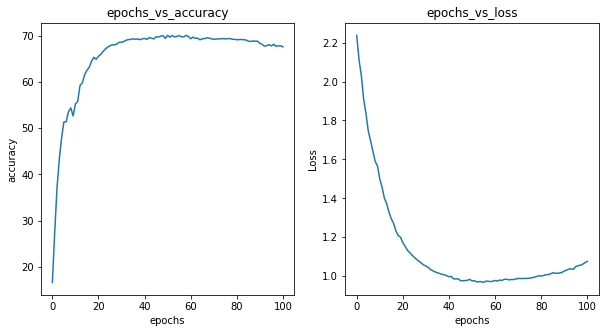

Training accuracy: 67.56666666666666 %
Testing accuracy: 65.95 %


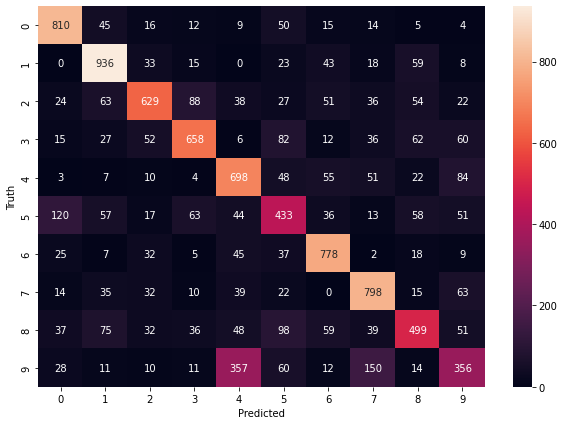

In [9]:
def load_mnist_dataset():
    f = gzip.open('mnist.pkl.gz', 'rb')
    if sys.version_info < (3,):
        data = pickle.load(f)
    else:
        data = pickle.load(f, encoding='bytes')
    f.close()

    return data

class tanh:
    @staticmethod
    def activation(x):
        y = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
        return y

    @staticmethod
    def prime(x):
        y = 1 - (tanh.activation(x) ** 2)
        return y

class sigmoid:
    @staticmethod
    def activation(x):
        y = 1 / (1 + np.exp(-x))
        return y

    @staticmethod
    def prime(x):
        y = sigmoid.activation(x) * (1 - sigmoid.activation(x))
        return y

class relu:
    @staticmethod
    def activation(x):
        y = np.maximum(0, x)
        return y

    @staticmethod
    def prime(x):
        x[x <= 0] = 0
        x[x > 0] = 1
        return x

class softmax:
    @staticmethod
    def activation(x):
        exps = np.exp(x - np.max(x))
        return exps / np.sum(exps, axis=1).reshape(-1, 1)

class Initialization:

    @staticmethod
    def Zeros(input_channel, output_channel):
        w = np.zeros((input_channel, output_channel))
        sdw = np.zeros((input_channel, output_channel))
        vdw = np.zeros((input_channel, output_channel))

        b = np.zeros((1, output_channel))
        sdb = np.zeros((1, output_channel))
        vdb = np.zeros((1, output_channel))

        return w, b, sdw, sdb, vdw, vdb

    @staticmethod
    def Xavier(input_channel, output_channel):
        w = np.random.randn(input_channel, output_channel) * np.sqrt(1 / input_channel)
        sdw = np.zeros((input_channel, output_channel))
        vdw = np.zeros((input_channel, output_channel))

        b = np.zeros((1, output_channel))
        sdb = np.zeros((1, output_channel))
        vdb = np.zeros((1, output_channel))

        return w, b, sdw, sdb, vdw, vdb

    @staticmethod
    def He(input_channel, output_channel):
        w = np.random.randn(input_channel, output_channel) * np.sqrt(2 / input_channel)
        sdw = np.zeros((input_channel, output_channel))
        vdw = np.zeros((input_channel, output_channel))

        b = np.zeros((1, output_channel))
        sdb = np.zeros((1, output_channel))
        vdb = np.zeros((1, output_channel))

        return w, b, sdw, sdb, vdw, vdb

    @staticmethod
    def Kumar(input_channel, output_channel):
        w = np.random.randn(input_channel, output_channel) * np.sqrt(12.96 / input_channel)
        sdw = np.zeros((input_channel, output_channel))
        vdw = np.zeros((input_channel, output_channel))

        b = np.zeros((1, output_channel))
        sdb = np.zeros((1, output_channel))
        vdb = np.zeros((1, output_channel))

        return w, b, sdw, sdb, vdw, vdb

class optimizers():

    @staticmethod
    def Newton(index, ddw, ddb, dw, db):
        model.layers[index].weight += np.matmul(np.linalg.inv(ddw), dw)
        model.layers[index].bias += ddb #np.matmul(np.linalg.inv(ddb), db)
        # print(f"model.layers[index].bias.shape={model.layers[index].bias.shape},model.layers[index].bias.type={type(model.layers[index].bias)}")

    @staticmethod
    def GD(index, dw, db, learning_rate):
        model.layers[index].weight -= learning_rate * dw
        model.layers[index].bias -= learning_rate * db

    @staticmethod
    def RMSprop(index, gamma, dw, db, vdw, vdb, learning_rate):
        vdw = gamma * vdw + (1 - gamma) * dw ** 2
        vdb = gamma * vdb + (1 - gamma) * db ** 2

        model.layers[index].weight -= (learning_rate / (np.sqrt(vdw + 1e-08))) * dw
        model.layers[index].bias -= (learning_rate / (np.sqrt(vdb + 1e-08))) * db

    @staticmethod
    def Adam(index, gamma1, gamma2, dw, db, mdw, mdb, vdw, vdb, currentepoch, alpha):
        mdw = gamma1 * mdw + (1 - gamma1) * dw
        mdb = gamma1 * mdb + (1 - gamma1) * db

        vdw = gamma2 * vdw + (1 - gamma2) * dw ** 2
        vdb = gamma2 * vdb + (1 - gamma2) * db ** 2

        mdw_corr = mdw / (1 - np.power(gamma1, currentepoch + 1))
        mdb_corr = mdb / (1 - np.power(gamma1, currentepoch + 1))

        vdw_corr = vdw / (1 - np.power(gamma2, currentepoch + 1))
        vdb_corr = vdb / (1 - np.power(gamma2, currentepoch + 1))

        model.layers[index].weight -= (alpha / (np.sqrt(vdw_corr + 1e-08))) * mdw_corr
        model.layers[index].bias -= (alpha / (np.sqrt(vdb_corr + 1e-08))) * mdb_corr

    @staticmethod
    def Adamax(index, gamma1, gamma2, dw, db, vdw, vdb, sdw, sdb, currentepoch, learning_rate):
        vdw = gamma1 * vdw + (1 - gamma1) * dw
        vdb = gamma1 * vdb + (1 - gamma1) * db

        sdw = np.maximum(gamma2 * sdw, np.abs(dw))
        sdb = np.maximum(gamma2 * sdb, np.abs(db))

        vdw_corr = vdw / (1 - np.power(gamma1, currentepoch + 1))
        vdb_corr = vdb / (1 - np.power(gamma1, currentepoch + 1))

        model.layers[index].weight -= (learning_rate / (np.sqrt(sdw + 1e-08))) * vdw_corr
        model.layers[index].bias -= (learning_rate / (np.sqrt(sdb + 1e-08))) * vdb_corr

class layers():
    class Dense():
        def __init__(self, input_channel, output_channel, activation=None, initialization=None):

            self.initialization = initialization

            if self.initialization == 'Xavier':
                self.weight, self.bias, self.sdw, self.sdb, self.vdw, self.vdb = \
                    Initialization.Xavier(input_channel, output_channel)
            elif self.initialization == 'He':
                self.weight, self.bias, self.sdw, self.sdb, self.vdw, self.vdb = \
                    Initialization.He(input_channel, output_channel)
            elif self.initialization == 'Kumar':
                self.weight, self.bias, self.sdw, self.sdb, self.vdw, self.vdb = \
                    Initialization.Kumar(input_channel, output_channel)
            else:
                self.weight, self.bias, self.sdw, self.sdb, self.vdw, self.vdb = \
                    Initialization.Zeros(input_channel, output_channel)

            model.activations.append(activation)
            self.activation = activation

        def forward(self, X):
            self.X = X

            z = np.dot(self.X, self.weight) + self.bias
            return z

        def backward(self):
            return self.X.T

class CategoricalCrossEntropy():
    def __init__(self, z, y_true):
        self.y_predict = z
        self.y_true = y_true

    def forward(self):
        m = self.y_predict.shape[0]

        return (-1) * (1 / m) * np.sum((self.y_true * np.log(self.y_predict)))

    def backward(self):
        delta = self.y_predict - self.y_true
        return delta

class BinaryCrossEntropy:
    def __init__(self, z, y_true):
        self.y_predict = z
        self.y_true = y_true

    def forward(self):
        m = self.y_predict.shape[0]
        return (-1) * (1 / m) * (np.sum((self.y_true * np.log(self.y_predict + 1e-8)) +
                                        ((1 - self.y_true) * (np.log(1 - self.y_predict + 1e-8)))))

    def backward(self):
        delta = self.y_predict - self.y_true
        return delta

class sequential():

    def __init__(self):
        self.layers = []
        self.activations = []
        self.Loss_list = []
        self.epochs_list = []
        self.accuracy_list = []

    def add(self, layer):
        self.layers.append(layer)
        return layer

    def compile(self, loss, optimizer):
        self.cost = loss
        self.optimizer = optimizer

    def GDScheduler(self, lr):
        self.learning_rate = lr

    def fit(self, X_train, y_train, batch_size, epochs):

        global cost_function, cost, accuracy
        global RMSprop_x_epochs, RMSprop_accuracy_list, RMSprop_y_loss
        # global newton_x_epochs, newton_accuracy_list, newton_y_loss
        m = X_train.shape[0]
        _z = []
        _a = []
        for i in range(epochs):
            current_epoch = i
            start = timeit.default_timer()

            for p in range(m // batch_size):

                k = p * batch_size
                l = (p + 1) * batch_size
                a = X_train[k:l]
                y = y_train[k:l]
                # Feed forward
                for j, eachLayer in enumerate(model.layers):
                    z = eachLayer.forward(a)
                    _z.append(z)
                    a = eval(model.activations[j]).activation(z)
                    _a.append(a)                                    # Storing activation values for back propogation

                # Calculating cost function
                if self.cost == 'BinaryCrossEntropy':
                    cost_function = 'BinaryCrossEntropy'

                if self.cost == 'CategoricalCrossEntropy':
                    cost_function = 'CategoricalCrossEntropy'

                loss = eval(cost_function)(a, y)
                cost = loss.forward()

                # Backpropagation
                delta = a - y
                deliver_delta = delta
                for j in reversed(range(1, len(model.layers))):

                    # print(f"_a[j - 1].T.shape={_a[j - 1].T.shape},deliver_delta.shape={deliver_delta.shape}")
                    dw = np.dot(_a[j - 1].T, deliver_delta)# (1 / m) *
                    db = np.sum(deliver_delta)# (1 / m) *
                    # print(f"dw.shape={dw.shape},db.shape={db.shape}, db.type={type(db)}, db={db}")
                    ddw =  (-1 / m) *np.dot(_a[j - 1].T, _a[j - 1]) #
                    # ddb = db
                    # print(f"ddw.shape={ddw.shape},db.shape={ddb.shape}, db.type={type(ddb)}, db={ddb}")



                    deliver_delta = np.dot(deliver_delta, model.layers[j].weight.T) * \
                                    eval(model.activations[j - 1]).prime(_z[j - 1])

                    # update parameters
                    if self.optimizer == 'Newton':
                        optimizers.Newton(j, ddw, db, dw, db)

                    if self.optimizer == 'GD':
                        optimizers.GD(j, dw, db, self.learning_rate)

                    if self.optimizer == 'RMSprop':
                        optimizers.RMSprop(j, 0.9, dw, db, model.layers[j].sdw, model.layers[j].sdb, self.learning_rate)

                    if self.optimizer == 'Adam':
                        optimizers.Adam(j, 0.9, 0.999, dw, db, model.layers[j].vdw, model.layers[j].vdb,
                                        model.layers[j].sdw, model.layers[j].sdb, current_epoch, self.learning_rate)

                    if self.optimizer == 'Adamax':
                        optimizers.Adamax(j, 0.9, 0.999, dw, db, model.layers[j].vdw, model.layers[j].vdb,
                                          model.layers[j].sdw, model.layers[j].sdb, current_epoch,
                                          self.learning_rate)

                accuracy = np.mean(np.equal(np.argmax(y, axis=-1), np.argmax(a, axis=-1))) * 100

            end = timeit.default_timer()

            print("epochs:" + str(i + 1) + " | " +
                  "runtime: {} s".format(float(round(end - start, 3))) + " | " +
                  "Loss:" + str(cost) + " | " +
                  "Accuracy: {} %".format(float(round(accuracy, 3))))

            #if i % 10 == 0:
            self.accuracy_list.append(accuracy)
            self.Loss_list.append(cost)
            self.epochs_list.append(i)

        # accuracy Plot
        accuracy_list = np.array(self.accuracy_list)
        accuracy_list = accuracy_list.reshape(-1, 1)

        # Loss Plot
        loss_array = np.array(self.Loss_list)
        y_loss = loss_array.reshape(-1, 1)
        x_epochs = np.array(self.epochs_list).reshape(-1, 1)

        accuracy_data = pd.DataFrame()
        accuracy_data['0'] = x_epochs.reshape(1, -1)[0]
        accuracy_data['1'] = accuracy_list.reshape(1, -1)[0]
        accuracy_data.to_csv('accuracy.txt', index=False, header=False, sep=" ")

        loss_data = pd.DataFrame()
        loss_data['0'] = x_epochs.reshape(1, -1)[0]
        loss_data['1'] = y_loss.reshape(1, -1)[0]
        loss_data.to_csv('cost.txt', index=False, header=False, sep=" ")

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.plot(x_epochs, accuracy_list)
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
        plt.title('epochs_vs_accuracy')
        plt.subplot(1, 2, 2)
        plt.plot(x_epochs, y_loss)
        plt.xlabel('epochs')
        plt.ylabel('Loss')
        plt.title('epochs_vs_loss')

        fig1 = plt.gcf()
        plt.show()
        fig1.savefig('Results.png')

        print("Training accuracy: {} %".format(accuracy))

        RMSprop_x_epochs     = x_epochs
        RMSprop_accuracy_list= accuracy_list
        RMSprop_y_loss       = y_loss

    @staticmethod
    def predict(x):

        a = x
        for j, eachLayer in enumerate(model.layers):
            z = eachLayer.forward(a)
            a = eval(model.activations[j]).activation(z)

        return a

    @staticmethod
    def confusion_matrix(data_array, labels):

        dim = len(data_array[0])
        cm = np.zeros((dim, dim), int)

        for i in range(len(data_array)):
            truth = np.argmax(data_array[i])
            predicted = np.argmax(labels[i])
            cm[truth, predicted] += 1

        plt.figure(figsize=(10, 7))
        sn.heatmap(cm, annot=True, fmt='d')
        plt.xlabel("Predicted")
        plt.ylabel("Truth")

        fig1 = plt.gcf()
        plt.show()
        fig1.savefig('cm.png')
        return cm

def evaluate(y_test, y_predicted):
    accuracy = np.mean(np.equal(np.argmax(y_test, axis=-1), np.argmax(y_predicted, axis=-1))) * 100
    print("Testing accuracy: {} %".format(accuracy))

if __name__ == '__main__':
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    X_train = X_train / 255
    X_test = X_test / 255

    y_train = tensorflow.keras.utils.to_categorical(y_train, 10).T
    y_test = tensorflow.keras.utils.to_categorical(y_test, 10).T

    X_train = X_train.reshape(-1, 28 * 28)
    X_test = X_test.reshape(-1, 28 * 28)
    y_train = y_train.T
    y_test = y_test.T

    model = sequential()

    model.add(layers.Dense(784, 100, activation='relu', initialization='He'))
    model.add(layers.Dense(100, 10, activation='softmax', initialization='He'))

    model.compile(loss='CategoricalCrossEntropy', optimizer='RMSprop')
    model.GDScheduler(lr=0.01)
    model.fit(X_train, y_train, batch_size=6000, epochs=101)

    y_predicted = model.predict(X_test)

    evaluate(y_test, y_predicted)
    model.confusion_matrix(y_test, y_predicted)

# global RMSprop_x_epochs
# global RMSprop_accuracy_list
# global RMSprop_y_loss

# Adamax Method

epochs:1 | runtime: 0.623 s | Loss:2.3878114956254404 | Accuracy: 31.717 %
epochs:2 | runtime: 0.72 s | Loss:1.8421053195279364 | Accuracy: 39.067 %
epochs:3 | runtime: 0.723 s | Loss:1.7017751066632871 | Accuracy: 54.933 %
epochs:4 | runtime: 0.696 s | Loss:1.622415522003101 | Accuracy: 60.717 %
epochs:5 | runtime: 0.647 s | Loss:1.5635432580889865 | Accuracy: 64.583 %
epochs:6 | runtime: 1.024 s | Loss:1.516920107996541 | Accuracy: 67.183 %
epochs:7 | runtime: 2.092 s | Loss:1.4791004275839519 | Accuracy: 67.65 %
epochs:8 | runtime: 2.048 s | Loss:1.4466505971296513 | Accuracy: 67.983 %
epochs:9 | runtime: 1.998 s | Loss:1.4177603556512695 | Accuracy: 68.283 %
epochs:10 | runtime: 1.974 s | Loss:1.3922789720719062 | Accuracy: 68.2 %
epochs:11 | runtime: 2.568 s | Loss:1.3694330798675407 | Accuracy: 68.817 %
epochs:12 | runtime: 3.662 s | Loss:1.3486914022465522 | Accuracy: 68.917 %
epochs:13 | runtime: 3.418 s | Loss:1.329593080210762 | Accuracy: 68.883 %
epochs:14 | runtime: 2.217 s

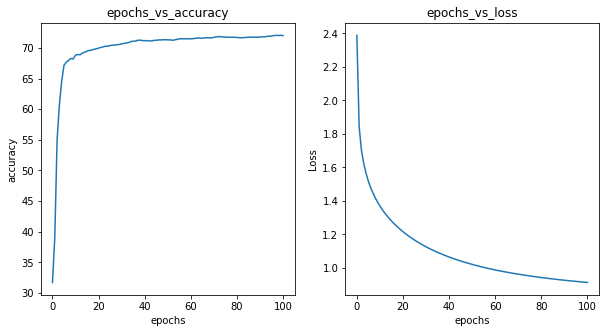

Training accuracy: 72.01666666666667 %
Testing accuracy: 69.86 %


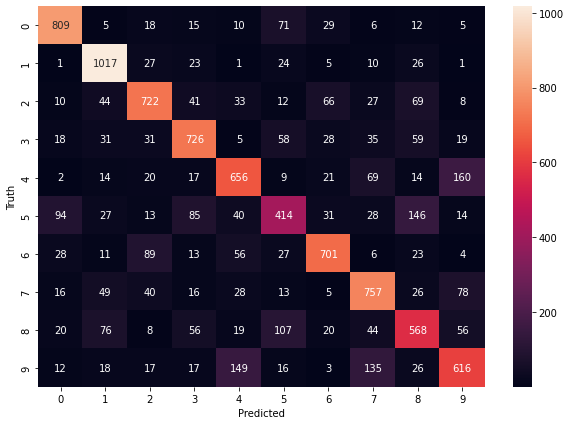

In [10]:
def load_mnist_dataset():
    f = gzip.open('mnist.pkl.gz', 'rb')
    if sys.version_info < (3,):
        data = pickle.load(f)
    else:
        data = pickle.load(f, encoding='bytes')
    f.close()

    return data

class tanh:
    @staticmethod
    def activation(x):
        y = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
        return y

    @staticmethod
    def prime(x):
        y = 1 - (tanh.activation(x) ** 2)
        return y

class sigmoid:
    @staticmethod
    def activation(x):
        y = 1 / (1 + np.exp(-x))
        return y

    @staticmethod
    def prime(x):
        y = sigmoid.activation(x) * (1 - sigmoid.activation(x))
        return y

class relu:
    @staticmethod
    def activation(x):
        y = np.maximum(0, x)
        return y

    @staticmethod
    def prime(x):
        x[x <= 0] = 0
        x[x > 0] = 1
        return x

class softmax:
    @staticmethod
    def activation(x):
        exps = np.exp(x - np.max(x))
        return exps / np.sum(exps, axis=1).reshape(-1, 1)

class Initialization:

    @staticmethod
    def Zeros(input_channel, output_channel):
        w = np.zeros((input_channel, output_channel))
        sdw = np.zeros((input_channel, output_channel))
        vdw = np.zeros((input_channel, output_channel))

        b = np.zeros((1, output_channel))
        sdb = np.zeros((1, output_channel))
        vdb = np.zeros((1, output_channel))

        return w, b, sdw, sdb, vdw, vdb

    @staticmethod
    def Xavier(input_channel, output_channel):
        w = np.random.randn(input_channel, output_channel) * np.sqrt(1 / input_channel)
        sdw = np.zeros((input_channel, output_channel))
        vdw = np.zeros((input_channel, output_channel))

        b = np.zeros((1, output_channel))
        sdb = np.zeros((1, output_channel))
        vdb = np.zeros((1, output_channel))

        return w, b, sdw, sdb, vdw, vdb

    @staticmethod
    def He(input_channel, output_channel):
        w = np.random.randn(input_channel, output_channel) * np.sqrt(2 / input_channel)
        sdw = np.zeros((input_channel, output_channel))
        vdw = np.zeros((input_channel, output_channel))

        b = np.zeros((1, output_channel))
        sdb = np.zeros((1, output_channel))
        vdb = np.zeros((1, output_channel))

        return w, b, sdw, sdb, vdw, vdb

    @staticmethod
    def Kumar(input_channel, output_channel):
        w = np.random.randn(input_channel, output_channel) * np.sqrt(12.96 / input_channel)
        sdw = np.zeros((input_channel, output_channel))
        vdw = np.zeros((input_channel, output_channel))

        b = np.zeros((1, output_channel))
        sdb = np.zeros((1, output_channel))
        vdb = np.zeros((1, output_channel))

        return w, b, sdw, sdb, vdw, vdb

class optimizers():

    @staticmethod
    def Newton(index, ddw, ddb, dw, db):
        model.layers[index].weight += np.matmul(np.linalg.inv(ddw), dw)
        model.layers[index].bias += ddb #np.matmul(np.linalg.inv(ddb), db)
        # print(f"model.layers[index].bias.shape={model.layers[index].bias.shape},model.layers[index].bias.type={type(model.layers[index].bias)}")

    @staticmethod
    def GD(index, dw, db, learning_rate):
        model.layers[index].weight -= learning_rate * dw
        model.layers[index].bias -= learning_rate * db

    @staticmethod
    def RMSprop(index, gamma, dw, db, vdw, vdb, learning_rate):
        vdw = gamma * vdw + (1 - gamma) * dw ** 2
        vdb = gamma * vdb + (1 - gamma) * db ** 2

        model.layers[index].weight -= (learning_rate / (np.sqrt(vdw + 1e-08))) * dw
        model.layers[index].bias -= (learning_rate / (np.sqrt(vdb + 1e-08))) * db

    @staticmethod
    def Adam(index, gamma1, gamma2, dw, db, mdw, mdb, vdw, vdb, currentepoch, alpha):
        mdw = gamma1 * mdw + (1 - gamma1) * dw
        mdb = gamma1 * mdb + (1 - gamma1) * db

        vdw = gamma2 * vdw + (1 - gamma2) * dw ** 2
        vdb = gamma2 * vdb + (1 - gamma2) * db ** 2

        mdw_corr = mdw / (1 - np.power(gamma1, currentepoch + 1))
        mdb_corr = mdb / (1 - np.power(gamma1, currentepoch + 1))

        vdw_corr = vdw / (1 - np.power(gamma2, currentepoch + 1))
        vdb_corr = vdb / (1 - np.power(gamma2, currentepoch + 1))

        model.layers[index].weight -= (alpha / (np.sqrt(vdw_corr + 1e-08))) * mdw_corr
        model.layers[index].bias -= (alpha / (np.sqrt(vdb_corr + 1e-08))) * mdb_corr

    @staticmethod
    def Adamax(index, gamma1, gamma2, dw, db, vdw, vdb, sdw, sdb, currentepoch, learning_rate):
        vdw = gamma1 * vdw + (1 - gamma1) * dw
        vdb = gamma1 * vdb + (1 - gamma1) * db

        sdw = np.maximum(gamma2 * sdw, np.abs(dw))
        sdb = np.maximum(gamma2 * sdb, np.abs(db))

        vdw_corr = vdw / (1 - np.power(gamma1, currentepoch + 1))
        vdb_corr = vdb / (1 - np.power(gamma1, currentepoch + 1))

        model.layers[index].weight -= (learning_rate / (np.sqrt(sdw + 1e-08))) * vdw_corr
        model.layers[index].bias -= (learning_rate / (np.sqrt(sdb + 1e-08))) * vdb_corr

class layers():
    class Dense():
        def __init__(self, input_channel, output_channel, activation=None, initialization=None):

            self.initialization = initialization

            if self.initialization == 'Xavier':
                self.weight, self.bias, self.sdw, self.sdb, self.vdw, self.vdb = \
                    Initialization.Xavier(input_channel, output_channel)
            elif self.initialization == 'He':
                self.weight, self.bias, self.sdw, self.sdb, self.vdw, self.vdb = \
                    Initialization.He(input_channel, output_channel)
            elif self.initialization == 'Kumar':
                self.weight, self.bias, self.sdw, self.sdb, self.vdw, self.vdb = \
                    Initialization.Kumar(input_channel, output_channel)
            else:
                self.weight, self.bias, self.sdw, self.sdb, self.vdw, self.vdb = \
                    Initialization.Zeros(input_channel, output_channel)

            model.activations.append(activation)
            self.activation = activation

        def forward(self, X):
            self.X = X

            z = np.dot(self.X, self.weight) + self.bias
            return z

        def backward(self):
            return self.X.T

class CategoricalCrossEntropy():
    def __init__(self, z, y_true):
        self.y_predict = z
        self.y_true = y_true

    def forward(self):
        m = self.y_predict.shape[0]

        return (-1) * (1 / m) * np.sum((self.y_true * np.log(self.y_predict)))

    def backward(self):
        delta = self.y_predict - self.y_true
        return delta

class BinaryCrossEntropy:
    def __init__(self, z, y_true):
        self.y_predict = z
        self.y_true = y_true

    def forward(self):
        m = self.y_predict.shape[0]
        return (-1) * (1 / m) * (np.sum((self.y_true * np.log(self.y_predict + 1e-8)) +
                                        ((1 - self.y_true) * (np.log(1 - self.y_predict + 1e-8)))))

    def backward(self):
        delta = self.y_predict - self.y_true
        return delta

class sequential():

    def __init__(self):
        self.layers = []
        self.activations = []
        self.Loss_list = []
        self.epochs_list = []
        self.accuracy_list = []

    def add(self, layer):
        self.layers.append(layer)
        return layer

    def compile(self, loss, optimizer):
        self.cost = loss
        self.optimizer = optimizer

    def GDScheduler(self, lr):
        self.learning_rate = lr

    def fit(self, X_train, y_train, batch_size, epochs):

        global cost_function, cost, accuracy
        global Adamax_x_epochs, Adamax_accuracy_list, Adamax_y_loss
        # global newton_x_epochs, newton_accuracy_list, newton_y_loss
        m = X_train.shape[0]
        _z = []
        _a = []
        for i in range(epochs):
            current_epoch = i
            start = timeit.default_timer()

            for p in range(m // batch_size):

                k = p * batch_size
                l = (p + 1) * batch_size
                a = X_train[k:l]
                y = y_train[k:l]
                # Feed forward
                for j, eachLayer in enumerate(model.layers):
                    z = eachLayer.forward(a)
                    _z.append(z)
                    a = eval(model.activations[j]).activation(z)
                    _a.append(a)                                    # Storing activation values for back propogation

                # Calculating cost function
                if self.cost == 'BinaryCrossEntropy':
                    cost_function = 'BinaryCrossEntropy'

                if self.cost == 'CategoricalCrossEntropy':
                    cost_function = 'CategoricalCrossEntropy'

                loss = eval(cost_function)(a, y)
                cost = loss.forward()

                # Backpropagation
                delta = a - y
                deliver_delta = delta
                for j in reversed(range(1, len(model.layers))):

                    # print(f"_a[j - 1].T.shape={_a[j - 1].T.shape},deliver_delta.shape={deliver_delta.shape}")
                    dw = np.dot(_a[j - 1].T, deliver_delta)# (1 / m) *
                    db = np.sum(deliver_delta)# (1 / m) *
                    # print(f"dw.shape={dw.shape},db.shape={db.shape}, db.type={type(db)}, db={db}")
                    ddw =  (-1 / m) *np.dot(_a[j - 1].T, _a[j - 1]) #
                    # ddb = db
                    # print(f"ddw.shape={ddw.shape},db.shape={ddb.shape}, db.type={type(ddb)}, db={ddb}")



                    deliver_delta = np.dot(deliver_delta, model.layers[j].weight.T) * \
                                    eval(model.activations[j - 1]).prime(_z[j - 1])

                    # update parameters
                    if self.optimizer == 'Newton':
                        optimizers.Newton(j, ddw, db, dw, db)

                    if self.optimizer == 'GD':
                        optimizers.GD(j, dw, db, self.learning_rate)

                    if self.optimizer == 'RMSprop':
                        optimizers.RMSprop(j, 0.9, dw, db, model.layers[j].sdw, model.layers[j].sdb, self.learning_rate)

                    if self.optimizer == 'Adam':
                        optimizers.Adam(j, 0.9, 0.999, dw, db, model.layers[j].vdw, model.layers[j].vdb,
                                        model.layers[j].sdw, model.layers[j].sdb, current_epoch, self.learning_rate)

                    if self.optimizer == 'Adamax':
                        optimizers.Adamax(j, 0.9, 0.999, dw, db, model.layers[j].vdw, model.layers[j].vdb,
                                          model.layers[j].sdw, model.layers[j].sdb, current_epoch,
                                          self.learning_rate)

                accuracy = np.mean(np.equal(np.argmax(y, axis=-1), np.argmax(a, axis=-1))) * 100

            end = timeit.default_timer()

            print("epochs:" + str(i + 1) + " | " +
                  "runtime: {} s".format(float(round(end - start, 3))) + " | " +
                  "Loss:" + str(cost) + " | " +
                  "Accuracy: {} %".format(float(round(accuracy, 3))))

            #if i % 10 == 0:
            self.accuracy_list.append(accuracy)
            self.Loss_list.append(cost)
            self.epochs_list.append(i)

        # accuracy Plot
        accuracy_list = np.array(self.accuracy_list)
        accuracy_list = accuracy_list.reshape(-1, 1)

        # Loss Plot
        loss_array = np.array(self.Loss_list)
        y_loss = loss_array.reshape(-1, 1)
        x_epochs = np.array(self.epochs_list).reshape(-1, 1)

        accuracy_data = pd.DataFrame()
        accuracy_data['0'] = x_epochs.reshape(1, -1)[0]
        accuracy_data['1'] = accuracy_list.reshape(1, -1)[0]
        accuracy_data.to_csv('accuracy.txt', index=False, header=False, sep=" ")

        loss_data = pd.DataFrame()
        loss_data['0'] = x_epochs.reshape(1, -1)[0]
        loss_data['1'] = y_loss.reshape(1, -1)[0]
        loss_data.to_csv('cost.txt', index=False, header=False, sep=" ")

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.plot(x_epochs, accuracy_list)
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
        plt.title('epochs_vs_accuracy')
        plt.subplot(1, 2, 2)
        plt.plot(x_epochs, y_loss)
        plt.xlabel('epochs')
        plt.ylabel('Loss')
        plt.title('epochs_vs_loss')

        fig1 = plt.gcf()
        plt.show()
        fig1.savefig('Results.png')

        print("Training accuracy: {} %".format(accuracy))

        Adamax_x_epochs     = x_epochs
        Adamax_accuracy_list= accuracy_list
        Adamax_y_loss       = y_loss

    @staticmethod
    def predict(x):

        a = x
        for j, eachLayer in enumerate(model.layers):
            z = eachLayer.forward(a)
            a = eval(model.activations[j]).activation(z)

        return a

    @staticmethod
    def confusion_matrix(data_array, labels):

        dim = len(data_array[0])
        cm = np.zeros((dim, dim), int)

        for i in range(len(data_array)):
            truth = np.argmax(data_array[i])
            predicted = np.argmax(labels[i])
            cm[truth, predicted] += 1

        plt.figure(figsize=(10, 7))
        sn.heatmap(cm, annot=True, fmt='d')
        plt.xlabel("Predicted")
        plt.ylabel("Truth")

        fig1 = plt.gcf()
        plt.show()
        fig1.savefig('cm.png')
        return cm

def evaluate(y_test, y_predicted):
    accuracy = np.mean(np.equal(np.argmax(y_test, axis=-1), np.argmax(y_predicted, axis=-1))) * 100
    print("Testing accuracy: {} %".format(accuracy))

if __name__ == '__main__':
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    X_train = X_train / 255
    X_test = X_test / 255

    y_train = tensorflow.keras.utils.to_categorical(y_train, 10).T
    y_test = tensorflow.keras.utils.to_categorical(y_test, 10).T

    X_train = X_train.reshape(-1, 28 * 28)
    X_test = X_test.reshape(-1, 28 * 28)
    y_train = y_train.T
    y_test = y_test.T

    model = sequential()

    model.add(layers.Dense(784, 100, activation='relu', initialization='He'))
    model.add(layers.Dense(100, 10, activation='softmax', initialization='He'))

    model.compile(loss='CategoricalCrossEntropy', optimizer='Adamax')
    model.GDScheduler(lr=0.01)
    model.fit(X_train, y_train, batch_size=6000, epochs=101)

    y_predicted = model.predict(X_test)

    evaluate(y_test, y_predicted)
    model.confusion_matrix(y_test, y_predicted)


# global Adamax_x_epochs
# global Adamax_accuracy_list
# global Adamax_y_loss

# Compare Results

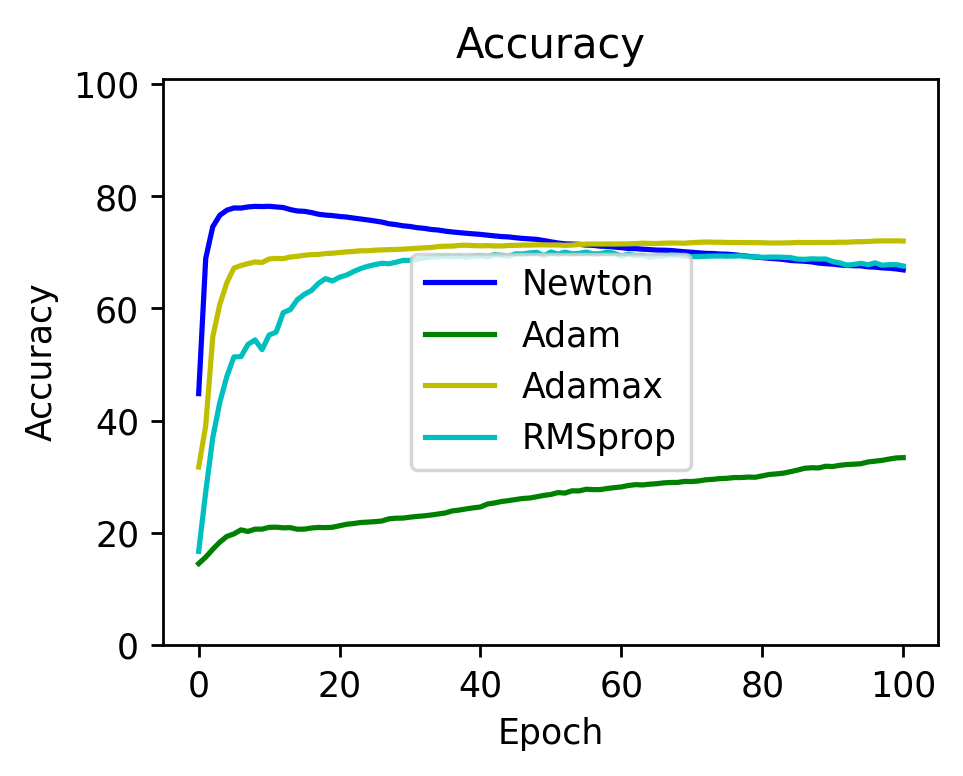

In [20]:
figure(figsize=(4, 3), dpi=250)
t = np.linspace(0,1,101)
# plt.plot(gd_x_epochs, gd_accuracy_list, 'r')
plt.plot(newton_x_epochs, newton_accuracy_list, 'b')
plt.plot(Adam_x_epochs, Adam_accuracy_list, 'g')
plt.plot(Adamax_x_epochs, Adamax_accuracy_list, 'y')
plt.plot(RMSprop_x_epochs, RMSprop_accuracy_list, 'c')
plt.ylim(0,101)
plt.legend([ "Newton","Adam", "Adamax", "RMSprop"])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

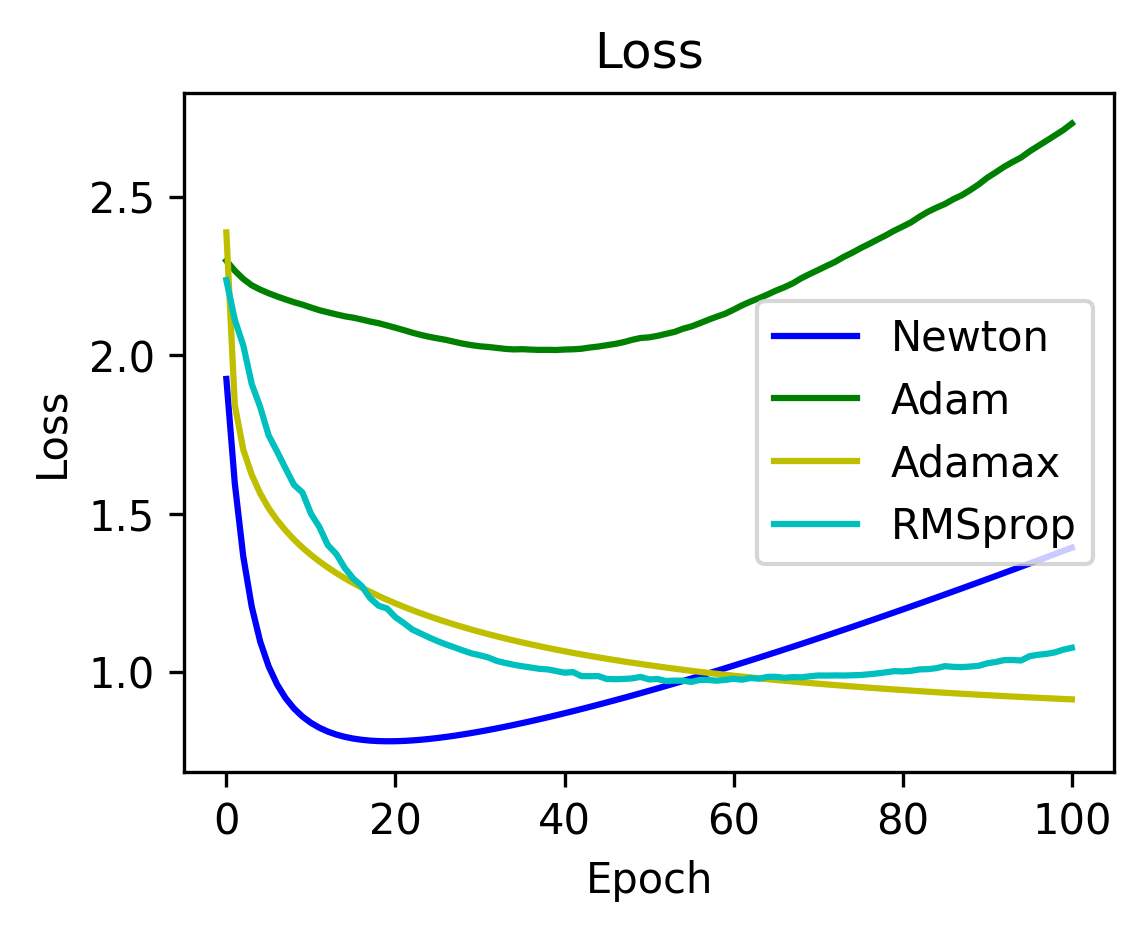

In [16]:
figure(figsize=(4, 3), dpi=300)
t = np.linspace(0,1,101)
# plt.plot(gd_x_epochs, gd_y_loss, 'r')
plt.plot(newton_x_epochs, newton_y_loss, 'b')
plt.plot(Adam_x_epochs, Adam_y_loss, 'g')
plt.plot(Adamax_x_epochs, Adamax_y_loss, 'y')
plt.plot(RMSprop_x_epochs, RMSprop_y_loss, 'c')
plt.legend(["Newton","Adam", "Adamax", "RMSprop"])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()